# PDFの解析を行うチャットボットの作成

---
---


本レポートでは主に以下サイトを参考に、chainlitとlangchainを利用して構築した、PDFを分析するチャットボットについてまとめる。

- [ローカルで気軽にRAGを使って会話することが簡単すぎてビビった。](https://qiita.com/mitsumizo/items/469d79c5e81d9189a9e4)

#### その他参考サイト

- [chainlit公式ドキュメント](https://docs.chainlit.io/get-started/overview)

- [langchain公式ドキュメント](https://python.langchain.com/docs/get_started/introduction/)

- [LangChainを用いて長文を要約しよう！map_reduce法/refine法](https://zenn.dev/tsuzukia/articles/05bfdcfcf5bd68)

- [Embedding（ベクトル化）についてイメージを掴む！](https://zenn.dev/peishim/articles/c696ff85a539bd)


...

## chainlitとは？
対話型AIのUIを作るためのライブラリ。

## langchainとは？
大規模言語モデルを利用してアプリケーションを作成するためのライブラリ。外部のデータベースや言語処理系と組み合わせて、高度な処理を行うアプリケーションを作成することができる。

いずれもpip installによってインストールを行う。



---

## アプリケーションの動かし方

- 本ドキュメントの最下部に記述されたコードを、任意の.pyファイルに貼り付ける。

- 次に、.env というファイルを作成し、その中に次のようにOpenAIのapiキーを記述する。

	OPENAI_API_KEY=あなたのOpenAI APIキー








- chainlitを起動するためには、.pyファイルが位置するディレクトリに移動し、以下のコマンドを実行する。

	chainlit run ファイル名 -w

上記の手順が完了すれば、アプリケーションがブラウザ上で起動するはずである。ここで任意のPDFファイルを渡し、質問を行うことができる。

---

# コードの解説

In [2]:
# ライブラリインポート
import dotenv
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import SpacyTextSplitter
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
import chainlit as cl

## OpenAI APIキーの取得方法

まず、dotenvを利用し、.envファイルからapiキーを変数名とともに辞書に格納する。

この変数に対し、.get("OPENAI_API_KEY", "")でapiキーのみを取得できる

In [4]:

env_values = dotenv.dotenv_values()
print(env_values)
print("\napiキーを抽出:\n", env_values.get("OPENAI_API_KEY", ""))

OrderedDict({'OPENAI_API_KEY': 'sk-sample'})

apiキーを抽出:
 sk-sample


---

# 処理の流れ



## PDFの処理

この節で扱うコードの全体を示す。ここでは、PDFの受け取りからOpenAIに渡すための前処理が行われる。

In [ ]:
@cl.on_chat_start
async def on_chat_start():
	"""初回起動時に呼び出される."""

	files = None

	# ここでファイルを受け取る。awaitメソッドのために、whileを利用する。アップロードされるまで続く。
	while files is None:
		# chainlitの機能に、ファイルをアップロードさせるメソッドがある。
		files = await cl.AskFileMessage(
			# ファイルの最大サイズ
			max_size_mb=20,
			# ファイルをアップロードさせる画面のメッセージ
			content="PDFを選択してください。",
			# PDFファイルを指定する
			accept=["application/pdf"],
			# タイムアウトなし
			raise_on_timeout=False,
		).send()


	file = files[0]


	# アップロードされたファイルのパスから中身を読み込む。
	documents = PyMuPDFLoader(file.path).load()
    # PDFを分割する処理
	text_splitter = SpacyTextSplitter(chunk_size=400, pipeline="ja_core_news_sm")
	splitted_documents = text_splitter.split_documents(documents)
	# テキストをベクトル化するOpenAIのモデル
	embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=env_values.get("OPENAI_API_KEY", ""))
	# Chromaにembedding APIを指定して、初期化する。
	database = Chroma(embedding_function=embeddings)
	# PDFから内容を分割されたドキュメントを保存する。
	database.add_documents(splitted_documents)
	# 今回は、簡易化のためセッションに保存する。
	cl.user_session.set("data", database)

アプリケーションを起動した時、まず @cl.on_chat_startが呼び出される。

In [12]:
@cl.on_chat_start
async def on_chat_start():
	python_codes = "sample"

これはchainlitの機能で、ユーザーがWebSocketを使ってサーバーに接続したときに特定の動作や処理を行うためのフックである。このフックを使うことで、WebSocket接続が確立されたときに特定の処理を行える。
このデコレータに紐づいた関数 on_chat_start でPDFの受け取りから、言語モデルが読み込めるようにするための処理が行われる。

本アプリケーションでは、このデコレータに紐づいた関数でPDFの受け取りから処理が行われている。その処理のうち、特にテキスト分割およびベクトル化については重要な概念なので、以下より解説を行う。

## テキスト分割

大規模言語モデルには、計算リソースの問題から一度に処理できるテキスト長には限りがある。

そこで、テキストをある単位ごとのチャンクに分割するという手法が取られる。

In [ ]:
# PDFを分割する処理
text_splitter = SpacyTextSplitter(chunk_size=400, pipeline="ja_core_news_sm")
splitted_documents = text_splitter.split_documents(documents) 

## テキストのベクトル化

大規模言語モデルはテキストの意味をそのままでは理解できない。そこで、テキストのベクトル化を行う。

テキストをベクトル化することによって、ニュアンスが類似したテキストを捜索することが可能となる。

In [ ]:
# テキストをベクトル化するOpenAIのモデル
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=env_values.get("OPENAI_API_KEY", ""))
# Chromaにembedding APIを指定して、初期化する。
database = Chroma(embedding_function=embeddings)

---

## チャットから受けた入力の処理

この節で扱うコードの全体を示す。

ここの処理では、PDFから得られたデータより、受け取った質問および、質問と関連性の高い内容をOpenAIに送る処理を行う。

In [ ]:
# プロンプトを定義
prompt = PromptTemplate(
    template="""
    文章を前提にして質問に答えてください。

    文章 :
    {document}

    質問 : {question}
    """,
    input_variables=["document", "question"],
)


# -----------------------------------------------------------------------------------------------------------------------------


@cl.on_message
async def on_message(input_message: cl.Message):
	"""メッセージが送られるたびに呼び出される."""
    
	# チャット用のOpenAIのモデル
	open_ai = ChatOpenAI(api_key=env_values.get("OPENAI_API_KEY", ""), model="gpt-4") # type: ignore


	# セッションからベクトルストアを取得（この中にPDFの内容がベクトル化されたものが格納されている）
	database = cl.user_session.get("data")
	# 質問された文から似た文字列を、DBより抽出
	documents = database.similarity_search(input_message.content)
	# 抽出したものを結合
	documents_string = ""
	for document in documents:
		documents_string += f"""
		---------------------------------------------
		{document.page_content}
		"""


	# プロンプトに埋め込みながらOpenAIに送信
	result = open_ai(
		[
			HumanMessage(
				content=prompt.format(
					document = database,
					# query = input_message.content,
					question = f"{input_message.content}: {documents}", # メッセージと一緒にドキュメントの内容も送信
				)
			)
		]
	).content

	# OpenAIから受け取った回答を表示
	await cl.Message(content=result, author="Answer").send()

以下はchainlitの機能で、チャットでメッセージを送信するごとに on_message 関数が呼び出される。チャットで入力した内容は、input_messageに格納されている。

In [ ]:
@cl.on_message
async def on_message(input_message: cl.Message):
	python_codes = "sample"

### プロンプトテンプレート

プロンプトテンプレートとは、言語モデルに入力するプロンプト生成のために事前に定義されるもの。( from langchain.prompts import PromptTemplate )
以下の例では、documentにPDFの内容、questionにチャットで入力した質問内容が格納される。

In [5]:
# プロンプトを定義
prompt = PromptTemplate(
    template="""
    文章を前提にして質問に答えてください。

    文章 :
    {document}

    質問 : {question}
    """,
    input_variables=["document", "question"],
)


以下でPDFデータの取得を行い、チャットから受けた質問に類似した文章データを抽出、結合する。

In [ ]:
# セッションからベクトルストアを取得（この中にPDFの内容がベクトル化されたものが格納されている）
database = cl.user_session.get("data")
# 質問された文から似た文字列を、DBより抽出
documents = database.similarity_search(input_message.content)
# 抽出したものを結合
documents_string = ""
for document in documents:
	documents_string += f"""
	---------------------------------------------
	{document.page_content}
	"""


次に、以下でopenAIに質問とPDFデータの送信を行う。

In [16]:
# プロンプトに埋め込みながらOpenAIに送信
result = open_ai(
	[
		HumanMessage(
			content=prompt.format(
				document = database,
				# query = input_message.content,
				question = f"{input_message.content}: {documents}", # メッセージと一緒にドキュメントの内容も送信
			)
		)
	]
).content

最後に、OpenAIから帰ってきた回答を表示

In [ ]:
await cl.Message(content=result, author="Answer").send()

---



# 実際の動作と課題

[2022 COMMUNICATIONS MARKETPLACE REPORT(アメリカの電気通信についてまとめた資料。322ページもある)](https://docs.fcc.gov/public/attachments/FCC-22-103A1.pdf)をチャットボットに渡して、PDFの解析をさせた。

受け答えは正常に動作しているものの、いくつか課題点も見られる。

.

一つ目の課題点が、曖昧な指示をすると、回答が中途半端かつ意図したものとは逸れることである。

「この文書について教えて」という質問を行ったところ、ファイルのメタデータやドキュメントの最後の方の、文書の趣旨とはあまり関係のないことを回答している。これは、分割されたチャンクから質問に関連した言葉を含むチャンクを送信するという仕組み上、質問の文章が曖昧だとユーザーが意図する情報を含んだチャンクが取得出来ないことが原因と考えられる。

二つ目の課題点として、英語の文書に対し、日本語のキーワードを入力して質問を送ると、その日本語キーワードに対応する文章の取得が行われないことである。

「解約率についてまとめてください」と質問をしたところ、"文書には解約率に関する情報は含まれていません"という返答になるが、「churnについてまとめて」という質問では、意図する回答が得られている。解約とchurnは意味することは同じであるが、ベクトル化されたデータにおいては類似しないものとされていると推測される。





以上のような問題があることから、実務に使用するためのLLMアプリの構築にはさらにチューニングが必要であることが伺える。


.

以下が[2022 COMMUNICATIONS MARKETPLACE REPORT](https://docs.fcc.gov/public/attachments/FCC-22-103A1.pdf)を分析させた様子

![スクリーンショット 2024-04-22 21.02.46.png](<attachment:スクリーンショット 2024-04-22 21.02.46.png>)
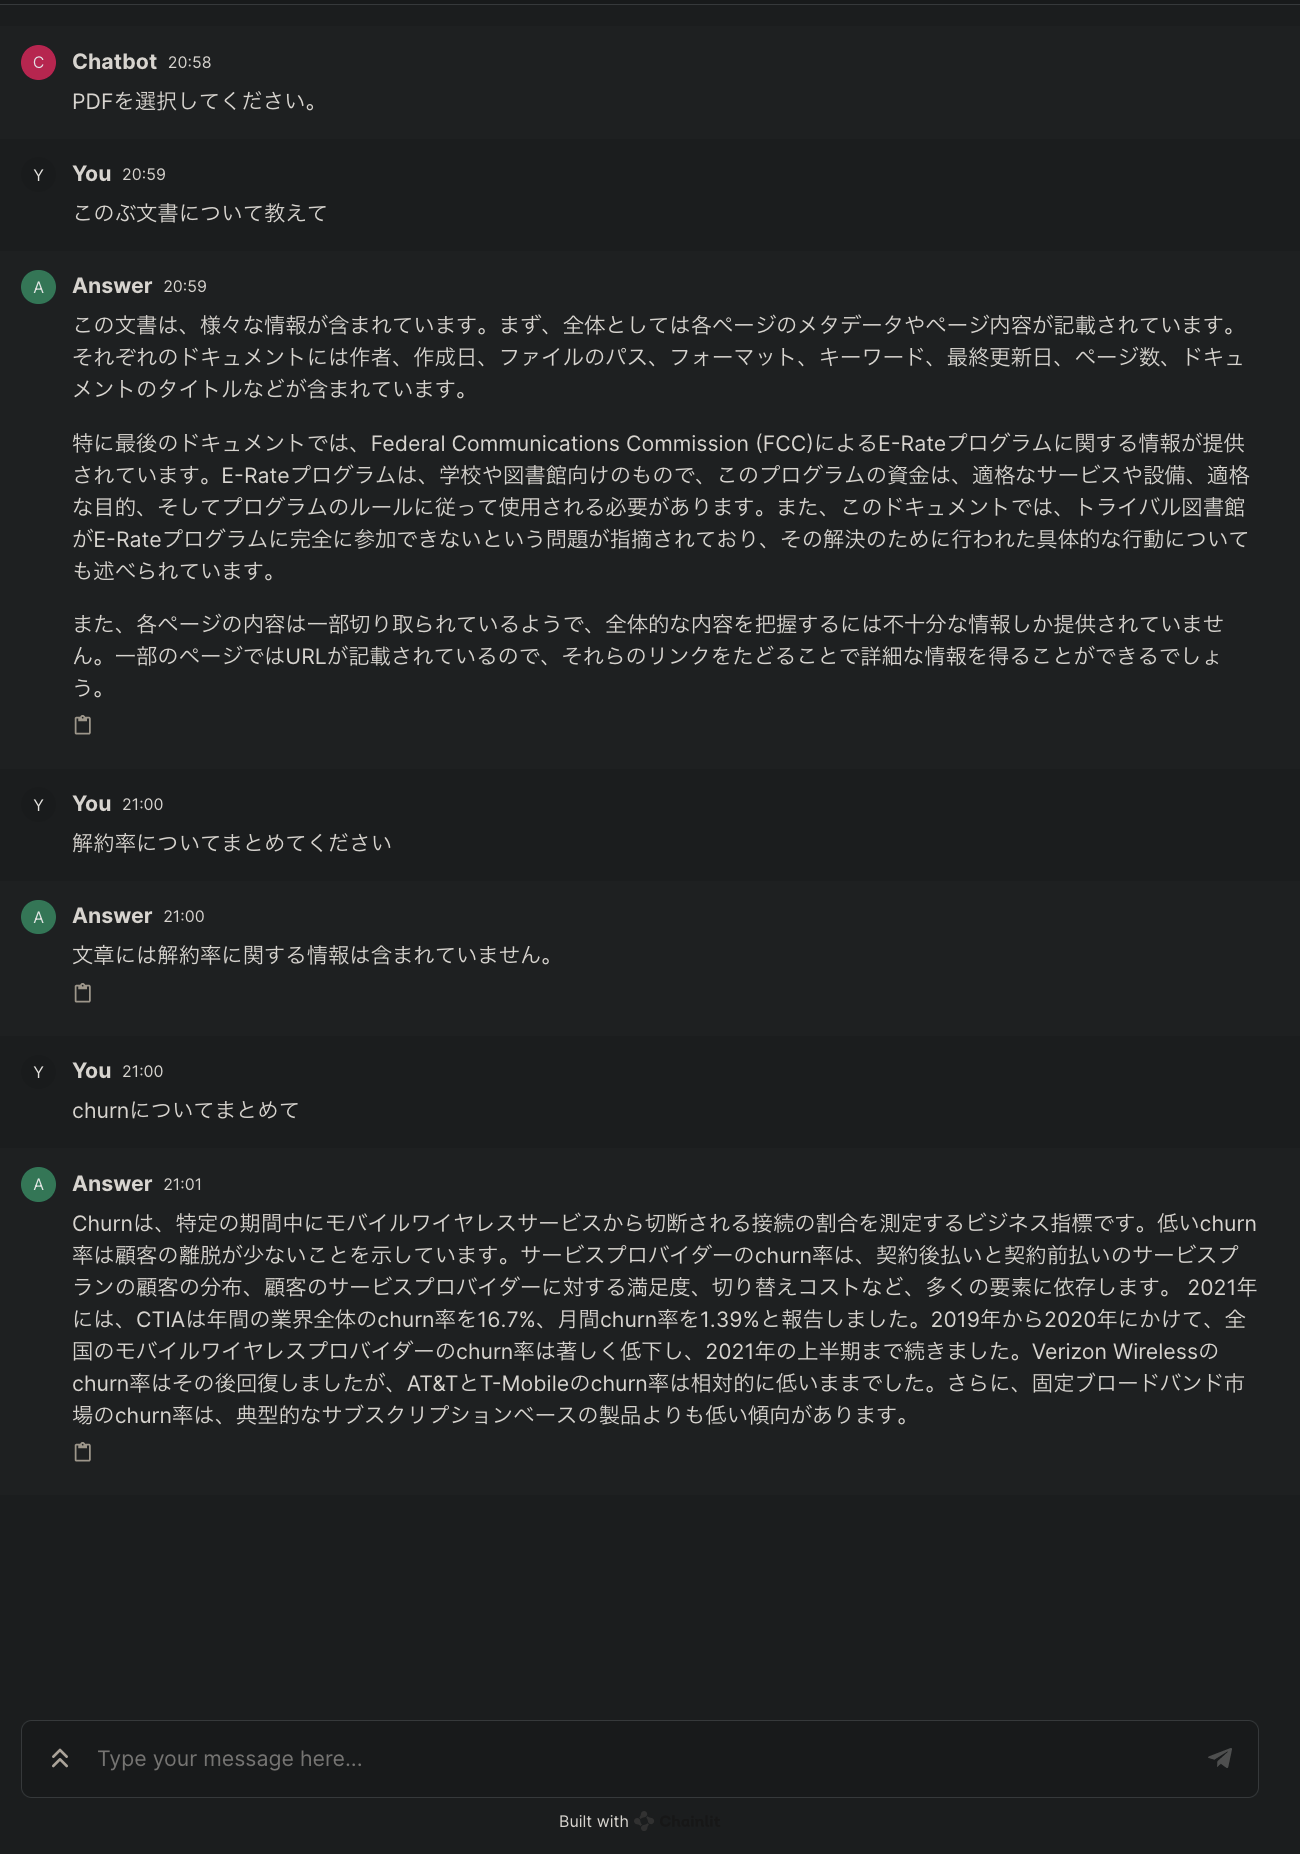

別のセッションで再度曖昧な質問を行った。ユーザーが意図した答えが返ってこない

![スクリーンショット 2024-04-22 21.27.55.png](<attachment:スクリーンショット 2024-04-22 21.27.55.png>)
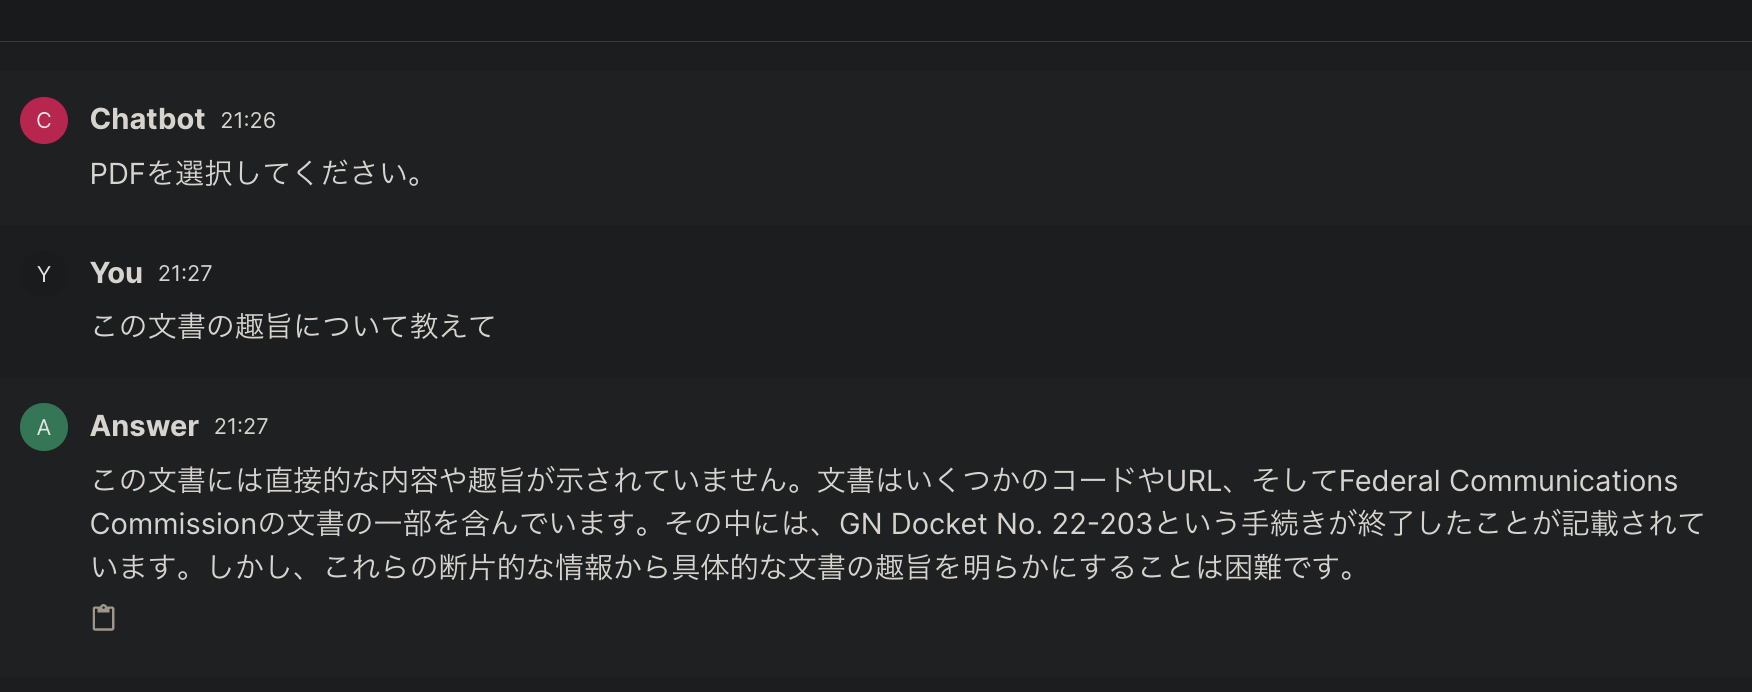

---

アプリの起動から処理のログ。PDFを渡したあと、テキスト分割の処理が行われている。

![スクリーンショット 2024-04-22 21.02.13.png](<attachment:スクリーンショット 2024-04-22 21.02.13.png>)
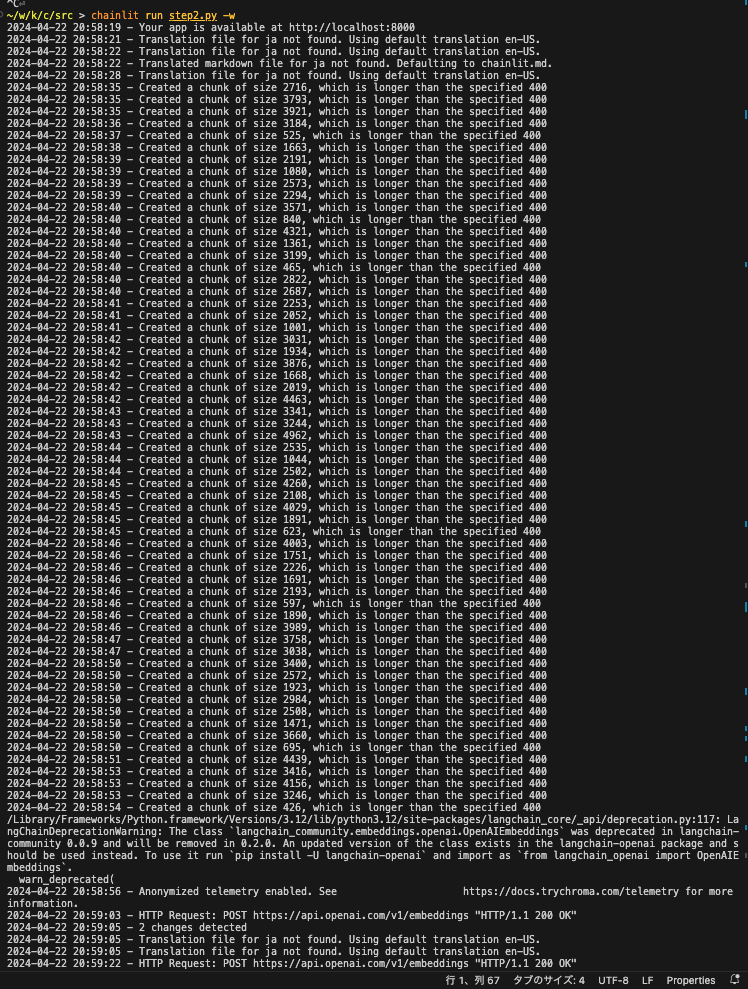

---

## ソースコード

In [17]:
import dotenv
from langchain.prompts import PromptTemplate
from langchain_community.document_loaders import PyMuPDFLoader
from langchain.text_splitter import SpacyTextSplitter
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.schema import HumanMessage
import chainlit as cl

env_values = dotenv.dotenv_values()

# プロンプトを定義
prompt = PromptTemplate(
    template="""
    文章を前提にして質問に答えてください。

    文章 :
    {document}

    質問 : {question}
    """,
    input_variables=["document", "question"],
)



@cl.on_chat_start
async def on_chat_start():
	"""初回起動時に呼び出される."""

	# PDFを読み込む処理
	files = None

	# awaitメソッドのために、whileを利用する。アップロードされるまで続く。
	while files is None:
		# chainlitの機能に、ファイルをアップロードさせるメソッドがある。
		files = await cl.AskFileMessage(
			# ファイルの最大サイズ
			max_size_mb=20,
			# ファイルをアップロードさせる画面のメッセージ
			content="PDFを選択してください。",
			# PDFファイルを指定する
			accept=["application/pdf"],
			# タイムアウトなし
			raise_on_timeout=False,
		).send()

	file = files[0]

	# アップロードされたファイルのパスから中身を読み込む。
	documents = PyMuPDFLoader(file.path).load()
    
    # PDFを分割する処理
	text_splitter = SpacyTextSplitter(chunk_size=400, pipeline="ja_core_news_sm")
	splitted_documents = text_splitter.split_documents(documents)

    # PDFの内容をベクトル化して保存する処理
	# テキストをベクトル化するOpenAIのモデル
	embeddings = OpenAIEmbeddings(model="text-embedding-ada-002", api_key=env_values.get("OPENAI_API_KEY", ""))

	# Chromaにembedding APIを指定して、初期化する。
	database = Chroma(embedding_function=embeddings)

	# PDFから内容を分割されたドキュメントを保存する。
	database.add_documents(splitted_documents)

	# 今回は、簡易化のためセッションに保存する。
	cl.user_session.set("data", database)




@cl.on_message
async def on_message(input_message: cl.Message):
	"""メッセージが送られるたびに呼び出される."""
    
	# チャット用のOpenAIのモデル
	open_ai = ChatOpenAI(api_key=env_values.get("OPENAI_API_KEY", ""), model="gpt-4") # type: ignore

	# セッションからベクトルストアを取得（この中にPDFの内容がベクトル化されたものが格納されている）
	database = cl.user_session.get("data")

	# 質問された文から似た文字列を、DBより抽出
	documents = database.similarity_search(input_message.content)

	# 抽出したものを結合
	documents_string = ""
	for document in documents:
		documents_string += f"""
		---------------------------------------------
		{document.page_content}
		"""

	# プロンプトに埋め込みながらOpenAIに送信
	result = open_ai(
		[
			HumanMessage(
				content=prompt.format(
					document = database,
					# query = input_message.content,
					question = f"{input_message.content}: {documents}", # メッセージと一緒にドキュメントの内容も送信
				)
			)
		]
	).content

	await cl.Message(content=result, author="Answer").send()
